# load data

In [27]:
import os

file_names = os.listdir('./dataset/img_align_celeba')
img_paths = ['./dataset/img_align_celeba/' + file_name for file_name in file_names]
len(img_paths)

202599

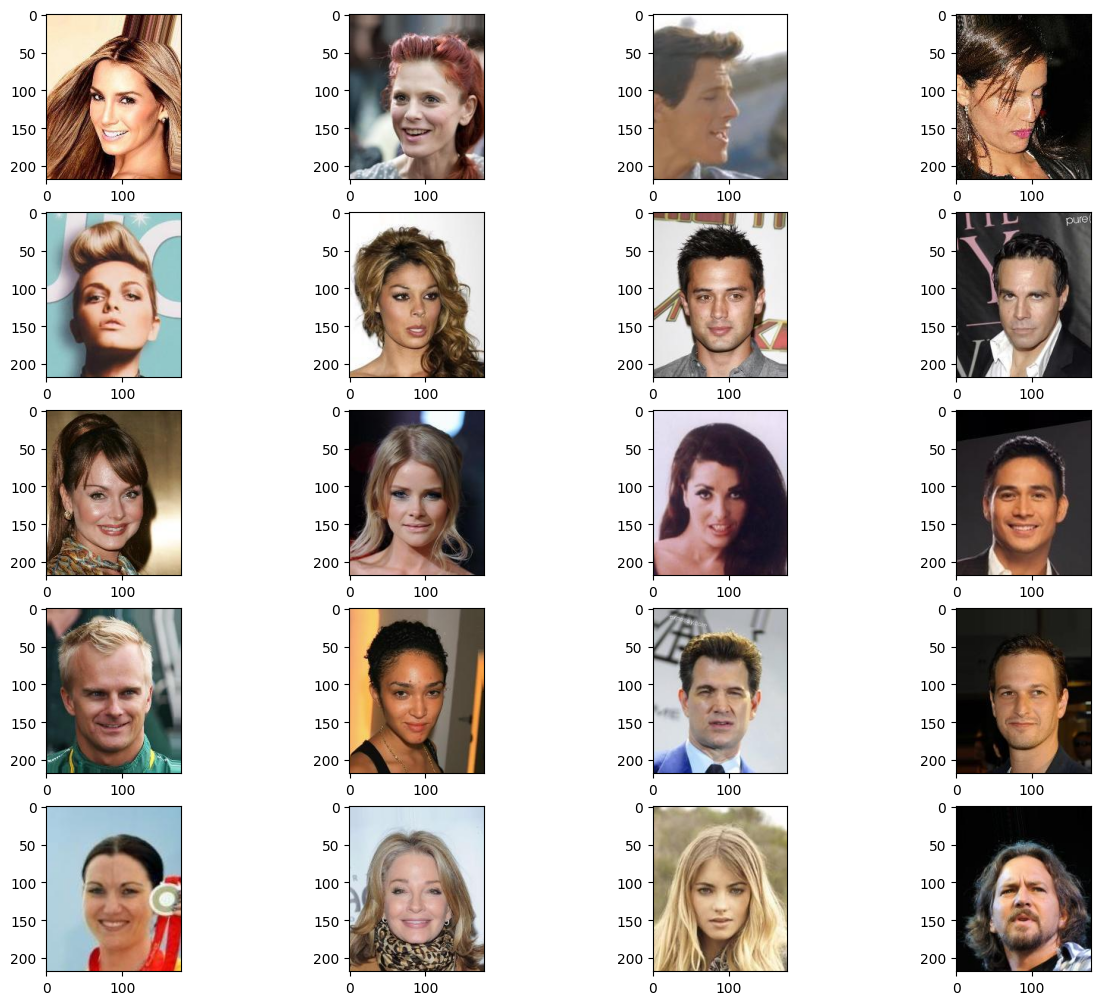

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
def show_images(file_names, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, img_path in enumerate(img_paths):
        if i == num_samples:
            break
        img = Image.open(img_path)
        img_np = np.array(img)
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img_np)
show_images(img_paths)

In [29]:
num_train, num_val = 1000, 100 # demo with small data
train_imgpaths = img_paths[ : num_train]
val_imgpaths = img_paths[num_train : num_train+num_val]

In [30]:
import numpy as np

def bbox2mask(img_shape, bbox, dtype='uint8'):
    """
    Generate mask in ndarray from bbox.
    bbox (tuple[int]): Configuration tuple, (top, left, height, width)
    """

    height, width = img_shape[:2]

    mask = np.zeros((height, width, 1), dtype=dtype)
    mask[bbox[0]:bbox[0] + bbox[2], bbox[1]:bbox[1] + bbox[3], :] = 1

    return mask

In [31]:
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset


class InpaintingDataset:
    def __init__(self, img_paths, mask_mode, image_size=[256, 256]):
        assert len(img_paths) >= 100, "Images path must be at least 100"
        self.img_paths = img_paths
        self.tfs = transforms.Compose(
            [
                transforms.Resize((image_size[0], image_size[1])),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ]
        )
        self.mask_mode = mask_mode
        self.image_size = image_size

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path).convert("RGB")
        img = self.tfs(img)
        mask = self.get_mask()
        # giữ lại phần không bị mask, phần mask biến thành noise gaussian
        cond_image = img * (1.0 - mask) + mask * torch.randn_like(img)
        # giữ lại phần không bị mask, phần mask có giá trị = 1
        mask_img = img * (1.0 - mask) + mask
        return {
            "gt_image": img,
            "cond_image": cond_image,
            "mask": mask,
            "mask_image": mask_img,
            "path": img_path,
        }

    def __len__(self):
        return len(self.img_paths)

    def get_mask(self):
        if self.mask_mode == "center":
            h, w = self.image_size
            mask = bbox2mask(self.image_size, (h // 4, w // 4, h // 2, w // 2))
        else:
            raise NotImplementedError(
                f"Mask mode {self.mask_mode} has not been implemented."
            )
        return torch.from_numpy(mask).permute(2, 0, 1)

In [32]:
dataset = InpaintingDataset(img_paths, mask_mode="center")

sample = dataset[19]

print(sample.keys())

dict_keys(['gt_image', 'cond_image', 'mask', 'mask_image', 'path'])


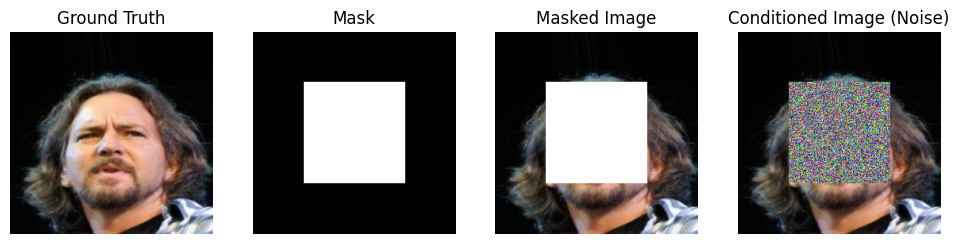

In [33]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Chuyển tensor về ảnh (range [0,1] để hiển thị)
def tensor_to_image(tensor):
    return F.to_pil_image((tensor + 1) / 2)  # Chuẩn hóa từ [-1,1] về [0,1]

gt_image = tensor_to_image(sample["gt_image"])       # Ảnh gốc
mask = tensor_to_image(sample["mask"])               # Mask
mask_img = tensor_to_image(sample["mask_image"])       # Ảnh bị che (1 tại vùng mask)
cond_image = tensor_to_image(sample["cond_image"])   # Ảnh có noise tại vùng mask

fig, axes = plt.subplots(1, 4, figsize=(12, 4))

axes[0].imshow(gt_image)
axes[0].set_title("Ground Truth")
axes[0].axis("off")

axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")

axes[2].imshow(mask_img)
axes[2].set_title("Masked Image")
axes[2].axis("off")

axes[3].imshow(cond_image)
axes[3].set_title("Conditioned Image (Noise)")
axes[3].axis("off")

plt.show()

In [34]:
train_dataset = InpaintingDataset(train_imgpaths, mask_mode='center')
val_dataset = InpaintingDataset(val_imgpaths, mask_mode='center')

In [35]:
from torch.utils.data import DataLoader

BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Model

## Simple Unet

In [36]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class LearnedTimeEmbeddings(nn.Module):
    def __init__(self, max_steps, dim):
        super().__init__()
        self.embedding = nn.Embedding(max_steps, dim)

    def forward(self, time):
        return self.embedding(time)


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self, max_time_steps):
        super().__init__()
        image_channels = 6
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                LearnedTimeEmbeddings(max_time_steps, time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep.long())
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat([x, residual_x], dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet(20)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62441251


SimpleUnet(
  (time_mlp): Sequential(
    (0): LearnedTimeEmbeddings(
      (embedding): Embedding(20, 32)
    )
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 

In [37]:
batch_size, c, h, w = 1, 6, 64, 64

input = torch.randn((batch_size, c, h, w))
emb = torch.ones((batch_size, ))
out = model(input, emb)

In [38]:
out.shape

torch.Size([1, 3, 64, 64])

## UNET by OpenAI

In [39]:
import math
import numpy as np
import torch
import torch.nn as nn


class GroupNorm32(nn.GroupNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


def scale_module(module, scale):
    """
    Scale the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().mul_(scale)
    return module


def mean_flat(tensor):
    """
    Take the mean over all non-batch dimensions.
    """
    return tensor.mean(dim=list(range(1, len(tensor.shape))))


def normalization(channels):
    """
    Make a standard normalization layer.

    :param channels: number of input channels.
    :return: an nn.Module for normalization.
    """
    return GroupNorm32(32, channels)



def checkpoint(func, inputs, params, flag):
    """
    Evaluate a function without caching intermediate activations, allowing for
    reduced memory at the expense of extra compute in the backward pass.

    :param func: the function to evaluate.
    :param inputs: the argument sequence to pass to `func`.
    :param params: a sequence of parameters `func` depends on but does not
                   explicitly take as arguments.
    :param flag: if False, disable gradient checkpointing.
    """
    if flag:
        args = tuple(inputs) + tuple(params)
        return CheckpointFunction.apply(func, len(inputs), *args)
    else:
        return func(*inputs)


class CheckpointFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, run_function, length, *args):
        ctx.run_function = run_function
        ctx.input_tensors = list(args[:length])
        ctx.input_params = list(args[length:])
        with torch.no_grad():
            output_tensors = ctx.run_function(*ctx.input_tensors)
        return output_tensors

    @staticmethod
    def backward(ctx, *output_grads):
        ctx.input_tensors = [x.detach().requires_grad_(True) for x in ctx.input_tensors]
        with torch.enable_grad():
            # Fixes a bug where the first op in run_function modifies the
            # Tensor storage in place, which is not allowed for detach()'d
            # Tensors.
            shallow_copies = [x.view_as(x) for x in ctx.input_tensors]
            output_tensors = ctx.run_function(*shallow_copies)
        input_grads = torch.autograd.grad(
            output_tensors,
            ctx.input_tensors + ctx.input_params,
            output_grads,
            allow_unused=True,
        )
        del ctx.input_tensors
        del ctx.input_params
        del output_tensors
        return (None, None) + input_grads


def count_flops_attn(model, _x, y):
    """
    A counter for the `thop` package to count the operations in an
    attention operation.
    Meant to be used like:
        macs, params = thop.profile(
            model,
            inputs=(inputs, timestamps),
            custom_ops={QKVAttention: QKVAttention.count_flops},
        )
    """
    b, c, *spatial = y[0].shape
    num_spatial = int(np.prod(spatial))
    # We perform two matmuls with the same number of ops.
    # The first computes the weight matrix, the second computes
    # the combination of the value vectors.
    matmul_ops = 2 * b * (num_spatial ** 2) * c
    model.total_ops += torch.DoubleTensor([matmul_ops])


def gamma_embedding(gammas, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.
    :param gammas: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=gammas.device)
    args = gammas[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

In [40]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

from abc import abstractmethod

class SiLU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class EmbedBlock(nn.Module):
    """
    Any module where forward() takes embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` embeddings.
        """

class EmbedSequential(nn.Sequential, EmbedBlock):
    """
    A sequential module that passes embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, EmbedBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x

class Upsample(nn.Module):
    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.

    """

    def __init__(self, channels, use_conv, out_channel=None):
        super().__init__()
        self.channels = channels
        self.out_channel = out_channel or channels
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(self.channels, self.out_channel, 3, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x

class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    """

    def __init__(self, channels, use_conv, out_channel=None):
        super().__init__()
        self.channels = channels
        self.out_channel = out_channel or channels
        self.use_conv = use_conv
        stride = 2
        if use_conv:
            self.op = nn.Conv2d(
                self.channels, self.out_channel, 3, stride=stride, padding=1
            )
        else:
            assert self.channels == self.out_channel
            self.op = nn.AvgPool2d(kernel_size=stride, stride=stride)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(EmbedBlock):
    """
    A residual block that can optionally change the number of channels.
    :param channels: the number of input channels.
    :param emb_channels: the number of embedding channels.
    :param dropout: the rate of dropout.
    :param out_channel: if specified, the number of out channels.
    :param use_conv: if True and out_channel is specified, use a spatial
        convolution instead of a smaller 1x1 convolution to change the
        channels in the skip connection.
    :param use_checkpoint: if True, use gradient checkpointing on this module.
    :param up: if True, use this block for upsampling.
    :param down: if True, use this block for downsampling.
    """

    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channel=None,
        use_conv=False,
        use_scale_shift_norm=False,
        use_checkpoint=False,
        up=False,
        down=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channel = out_channel or channels
        self.use_conv = use_conv
        self.use_checkpoint = use_checkpoint
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            normalization(channels),
            SiLU(),
            nn.Conv2d(channels, self.out_channel, 3, padding=1),
        )

        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False)
            self.x_upd = Upsample(channels, False)
        elif down:
            self.h_upd = Downsample(channels, False)
            self.x_upd = Downsample(channels, False)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            SiLU(),
            nn.Linear(
                emb_channels,
                2 * self.out_channel if use_scale_shift_norm else self.out_channel,
            ),
        )
        self.out_layers = nn.Sequential(
            normalization(self.out_channel),
            SiLU(),
            nn.Dropout(p=dropout),
            zero_module(
                nn.Conv2d(self.out_channel, self.out_channel, 3, padding=1)
            ),
        )

        if self.out_channel == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = nn.Conv2d(
                channels, self.out_channel, 3, padding=1
            )
        else:
            self.skip_connection = nn.Conv2d(channels, self.out_channel, 1)

    def forward(self, x, emb):
        """
        Apply the block to a Tensor, conditioned on a embedding.
        :param x: an [N x C x ...] Tensor of features.
        :param emb: an [N x emb_channels] Tensor of embeddings.
        :return: an [N x C x ...] Tensor of outputs.
        """
        return checkpoint(
            self._forward, (x, emb), self.parameters(), self.use_checkpoint
        )

    def _forward(self, x, emb):
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h

class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.
    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(
        self,
        channels,
        num_heads=1,
        num_head_channels=-1,
        use_checkpoint=False,
        use_new_attention_order=False,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert (
                channels % num_head_channels == 0
            ), f"q,k,v channels {channels} is not divisible by num_head_channels {num_head_channels}"
            self.num_heads = channels // num_head_channels
        self.use_checkpoint = use_checkpoint
        self.norm = normalization(channels)
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        if use_new_attention_order:
            # split qkv before split heads
            self.attention = QKVAttention(self.num_heads)
        else:
            # split heads before split qkv
            self.attention = QKVAttentionLegacy(self.num_heads)

        self.proj_out = zero_module(nn.Conv1d(channels, channels, 1))

    def forward(self, x):
        return checkpoint(self._forward, (x,), self.parameters(), True)

    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


class QKVAttentionLegacy(nn.Module):
    """
    A module which performs QKV attention. Matches legacy QKVAttention + input/ouput heads shaping
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (H * 3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(ch, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class QKVAttention(nn.Module):
    """
    A module which performs QKV attention and splits in a different order.
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (3 * H * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.chunk(3, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum(
            "bct,bcs->bts",
            (q * scale).view(bs * self.n_heads, ch, length),
            (k * scale).view(bs * self.n_heads, ch, length),
        )  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v.reshape(bs * self.n_heads, ch, length))
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)

class UNet(nn.Module):
    """
    The full UNet model with attention and embedding.
    :param in_channel: channels in the input Tensor, for image colorization : Y_channels + X_channels .
    :param inner_channel: base channel count for the model.
    :param out_channel: channels in the output Tensor.
    :param res_blocks: number of residual blocks per downsample.
    :param attn_res: a collection of downsample rates at which
        attention will take place. May be a set, list, or tuple.
        For example, if this contains 4, then at 4x downsampling, attention
        will be used.
    :param dropout: the dropout probability.
    :param channel_mults: channel multiplier for each level of the UNet.
    :param conv_resample: if True, use learned convolutions for upsampling and
        downsampling.
    :param use_checkpoint: use gradient checkpointing to reduce memory usage.
    :param num_heads: the number of attention heads in each attention layer.
    :param num_heads_channels: if specified, ignore num_heads and instead use
                               a fixed channel width per attention head.
    :param num_heads_upsample: works with num_heads to set a different number
                               of heads for upsampling. Deprecated.
    :param use_scale_shift_norm: use a FiLM-like conditioning mechanism.
    :param resblock_updown: use residual blocks for up/downsampling.
    :param use_new_attention_order: use a different attention pattern for potentially
                                    increased efficiency.
    """

    def __init__(
        self,
        image_size,
        in_channel,
        inner_channel,
        out_channel,
        res_blocks,
        attn_res,
        dropout=0,
        channel_mults=(1, 2, 4, 8),
        conv_resample=True,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=True,
        resblock_updown=True,
        use_new_attention_order=False,
    ):

        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.image_size = image_size
        self.in_channel = in_channel
        self.inner_channel = inner_channel
        self.out_channel = out_channel
        self.res_blocks = res_blocks
        self.attn_res = attn_res
        self.dropout = dropout
        self.channel_mults = channel_mults
        self.conv_resample = conv_resample
        self.use_checkpoint = use_checkpoint
        self.dtype = torch.float16 if use_fp16 else torch.float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample

        cond_embed_dim = inner_channel * 4
        self.cond_embed = nn.Sequential(
            nn.Linear(inner_channel, cond_embed_dim),
            SiLU(),
            nn.Linear(cond_embed_dim, cond_embed_dim),
        )

        ch = input_ch = int(channel_mults[0] * inner_channel)
        self.input_blocks = nn.ModuleList(
            [EmbedSequential(nn.Conv2d(in_channel, ch, 3, padding=1))]
        )
        self._feature_size = ch
        input_block_chans = [ch]
        ds = 1
        for level, mult in enumerate(channel_mults):
            for _ in range(res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        cond_embed_dim,
                        dropout,
                        out_channel=int(mult * inner_channel),
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(mult * inner_channel)
                if ds in attn_res:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                self.input_blocks.append(EmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mults) - 1:
                out_ch = ch
                self.input_blocks.append(
                    EmbedSequential(
                        ResBlock(
                            ch,
                            cond_embed_dim,
                            dropout,
                            out_channel=out_ch,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                        )
                        if resblock_updown
                        else Downsample(
                            ch, conv_resample, out_channel=out_ch
                        )
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        self.middle_block = EmbedSequential(
            ResBlock(
                ch,
                cond_embed_dim,
                dropout,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                use_new_attention_order=use_new_attention_order,
            ),
            ResBlock(
                ch,
                cond_embed_dim,
                dropout,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )
        self._feature_size += ch

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mults))[::-1]:
            for i in range(res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [
                    ResBlock(
                        ch + ich,
                        cond_embed_dim,
                        dropout,
                        out_channel=int(inner_channel * mult),
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(inner_channel * mult)
                if ds in attn_res:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads_upsample,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                if level and i == res_blocks:
                    out_ch = ch
                    layers.append(
                        ResBlock(
                            ch,
                            cond_embed_dim,
                            dropout,
                            out_channel=out_ch,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            up=True,
                        )
                        if resblock_updown
                        else Upsample(ch, conv_resample, out_channel=out_ch)
                    )
                    ds //= 2
                self.output_blocks.append(EmbedSequential(*layers))
                self._feature_size += ch

        self.out = nn.Sequential(
            normalization(ch),
            SiLU(),
            zero_module(nn.Conv2d(input_ch, out_channel, 3, padding=1)),
        )

    def forward(self, x, gammas):
        """
        Apply the model to an input batch.
        :param x: an [N x 2 x ...] Tensor of inputs (B&W)
        :param gammas: a 1-D batch of gammas.
        :return: an [N x C x ...] Tensor of outputs.
        """
        hs = []
        gammas = gammas.view(-1, )
        emb = self.cond_embed(gamma_embedding(gammas, self.inner_channel))

        h = x.type(torch.float32)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            h = torch.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
        h = h.type(x.dtype)
        return self.out(h)

In [41]:
batch_size, c, h, w = 3, 6, 64, 64
timsteps = 100
model = UNet(
    image_size=h,
    in_channel=c,
    inner_channel=64,
    out_channel=3,
    res_blocks=2,
    attn_res=[8]
)
input = torch.randn((batch_size, c, h, w))
emb = torch.ones((batch_size, ))
out = model(input, emb)

In [42]:
out.shape

torch.Size([3, 3, 64, 64])

## Inpainting Gaussian Diffusion Model

In [43]:
device = 'cuda'
def make_beta_schedule(schedule, n_timestep, linear_start=1e-5, linear_end=1e-2):
    if schedule == 'linear':
        betas = np.linspace(
            linear_start, linear_end, n_timestep, dtype=np.float64
        )
    else:
        raise NotImplementedError(schedule)
    return betas

def get_index_from_list(vals, t, x_shape=(1,1,1,1)):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size, *_ = t.shape
    out = vals.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(device)

In [44]:
from tqdm import tqdm
from functools import partial


class InpaintingGaussianDiffusion(nn.Module):
    def __init__(self, unet_config, beta_schedule, **kwargs):
        super(InpaintingGaussianDiffusion, self).__init__(**kwargs)
        self.denoise_fn = UNet(**unet_config)
        self.beta_schedule = beta_schedule

    def set_new_noise_schedule(self, device):
        to_torch = partial(torch.tensor, dtype=torch.float32, device=device)
        betas = make_beta_schedule(**self.beta_schedule)
        alphas = 1.0 - betas
        (timesteps,) = betas.shape
        self.num_timesteps = int(timesteps)

        gammas = np.cumprod(alphas, axis=0)  # alphas_cumprod
        gammas_prev = np.append(1.0, gammas[:-1])

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer("gammas", to_torch(gammas))
        self.register_buffer("sqrt_recip_gammas", to_torch(np.sqrt(1.0 / gammas)))
        self.register_buffer("sqrt_recipm1_gammas", to_torch(np.sqrt(1.0 / gammas - 1)))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * (1.0 - gammas_prev) / (1.0 - gammas)
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer(
            "posterior_log_variance_clipped",
            to_torch(np.log(np.maximum(posterior_variance, 1e-20))),
        )
        self.register_buffer(
            "posterior_mean_coef1",
            to_torch(betas * np.sqrt(gammas_prev) / (1.0 - gammas)),
        )
        self.register_buffer(
            "posterior_mean_coef2",
            to_torch((1.0 - gammas_prev) * np.sqrt(alphas) / (1.0 - gammas)),
        )

    def set_loss(self, loss_fn):
        self.loss_fn = loss_fn

    def predict_start_from_noise(self, y_t, t, noise):
        return (
            get_index_from_list(self.sqrt_recip_gammas, t, y_t.shape) * y_t
            - get_index_from_list(self.sqrt_recipm1_gammas, t, y_t.shape) * noise
        )

    def q_posterior(self, y_0_hat, y_t, t):
        """
        Compute the mean and variance of the diffusion posterior:

            q(x_{t-1} | x_t, x_0)

        """
        posterior_mean = (
            get_index_from_list(self.posterior_mean_coef1, t, y_t.shape) * y_0_hat
            + get_index_from_list(self.posterior_mean_coef2, t, y_t.shape) * y_t
        )
        posterior_log_variance_clipped = get_index_from_list(
            self.posterior_log_variance_clipped, t, y_t.shape
        )
        return posterior_mean, posterior_log_variance_clipped

    def p_mean_variance(self, y_t, t, clip_denoised: bool, y_cond=None):
        noise_level = get_index_from_list(self.gammas, t, x_shape=(1, 1)).to(y_t.device)
        y_0_hat = self.predict_start_from_noise(
            y_t,
            t=t,
            noise=self.denoise_fn(torch.cat([y_cond, y_t], dim=1), noise_level),
        )

        if clip_denoised:
            y_0_hat.clamp_(-1.0, 1.0)

        model_mean, posterior_log_variance = self.q_posterior(
            y_0_hat=y_0_hat, y_t=y_t, t=t
        )
        return model_mean, posterior_log_variance

    def q_sample(self, y_0, sample_gammas, noise=None):
        noise = noise if noise is not None else torch.randn_like(y_0)
        return sample_gammas.sqrt() * y_0 + (1 - sample_gammas).sqrt() * noise

    @torch.no_grad()
    def p_sample(self, y_t, t, clip_denoised=True, y_cond=None):
        model_mean, model_log_variance = self.p_mean_variance(
            y_t=y_t, t=t, clip_denoised=clip_denoised, y_cond=y_cond
        )
        noise = torch.randn_like(y_t) if any(t > 0) else torch.zeros_like(y_t)
        return model_mean + noise * (0.5 * model_log_variance).exp()

    @torch.no_grad()
    def restoration(self, y_cond, y_t=None, y_0=None, mask=None, sample_num=8):
        b, *_ = y_cond.shape

        sample_inter = self.num_timesteps // sample_num

        y_t = y_t if y_t is not None else torch.randn_like(y_cond)
        ret_arr = y_t
        for i in reversed(range(0, self.num_timesteps)):
            t = torch.full((b,), i, device=y_cond.device, dtype=torch.long)
            y_t = self.p_sample(y_t, t, y_cond=y_cond)
            if mask is not None:
                y_t = y_0 * (1.0 - mask) + mask * y_t
            if i % sample_inter == 0:
                ret_arr = torch.cat([ret_arr, y_t], dim=0)
        return y_t, ret_arr

    def forward(self, y_0, y_cond=None, mask=None, noise=None):
        # sampling from p( gammas )
        b, *_ = y_0.shape
        t = torch.randint(1, self.num_timesteps, (b,), device=y_0.device).long()
        gamma_t1 = get_index_from_list(self.gammas, t - 1, x_shape=(1, 1))
        sqrt_gamma_t2 = get_index_from_list(self.gammas, t, x_shape=(1, 1))
        sample_gammas = (sqrt_gamma_t2 - gamma_t1) * torch.rand(
            (b, 1), device=y_0.device
        ) + gamma_t1
        sample_gammas = sample_gammas.view(b, -1)
        noise = noise if noise is not None else torch.randn_like(y_0)
        y_noisy = self.q_sample(
            y_0=y_0, sample_gammas=sample_gammas.view(-1, 1, 1, 1), noise=noise
        )
        if mask is not None:
            noise_hat = self.denoise_fn(
                torch.cat([y_cond, y_noisy * mask + (1.0 - mask) * y_0], dim=1),
                sample_gammas,
            )
            loss = self.loss_fn(mask * noise, mask * noise_hat)
        else:
            noise_hat = self.denoise_fn(
                torch.cat([y_cond, y_noisy], dim=1), sample_gammas
            )
            loss = self.loss_fn(noise, noise_hat)
        return loss

In [139]:
unet_config = {
    "in_channel": 6,
    "out_channel": 3,
    "inner_channel": 64,
    "channel_mults": [1, 2, 4, 8],
    "attn_res": [16],
    "num_head_channels": 32,
    "res_blocks": 2,
    "dropout": 0.2,
    "image_size": 256
}

beta_schedule = {
    "schedule": "linear",
    "n_timestep": 20,
    "linear_start": 1e-4,
    "linear_end": 0.09
}

In [46]:
inpainting_model = InpaintingGaussianDiffusion(unet_config, beta_schedule)

In [47]:
inpainting_model

InpaintingGaussianDiffusion(
  (denoise_fn): UNet(
    (cond_embed): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (input_blocks): ModuleList(
      (0): EmbedSequential(
        (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x EmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (h_upd): Identity()
          (x_upd): Identity()
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=256, out_features=128, bias=True)
          )
          (out_layers): Sequential(
            (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Dropout(p=

In [48]:
import torch.nn.functional as F

def mse_loss(output, target):
    return F.mse_loss(output, target)


def mae(input, target):
    with torch.no_grad():
        loss = nn.L1Loss()
        output = loss(input, target)
    return output

## Trainer

In [49]:
import time

class Trainer():
    def __init__(self, model, optimizers, train_loader, val_loader, epochs, sample_num, device, save_model):
        self.model = model.to(device)
        self.optimizer = torch.optim.Adam(list(filter(
            lambda p: p.requires_grad, self.model.parameters()
        )), **optimizers)
        self.model.set_loss(mse_loss)
        self.model.set_new_noise_schedule(device)
        self.sample_num = sample_num
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.epochs = epochs
        self.save_model = save_model + "/best_model.pth"

    def train_step(self):
        self.model.train()
        losses = []
        for batch in tqdm(self.train_loader):
            gt_image = batch['gt_image'].to(self.device)
            cond_image = batch['cond_image'].to(self.device)
            mask = batch['mask'].to(self.device)
            mask_image = batch['mask_image'].to(self.device)
            batch_size = len(batch['path'])

            self.optimizer.zero_grad()

            loss = self.model(gt_image, cond_image, mask=mask)
            loss.backward()
            losses.append(loss.item())
            self.optimizer.step()
        return sum(losses)/len(losses)

    def val_step(self):
        self.model.eval()
        losses, metrics = [], []
        with torch.no_grad():
            for batch in tqdm(self.val_loader):
                gt_image = batch['gt_image'].to(self.device)
                cond_image = batch['cond_image'].to(self.device)
                mask = batch['mask'].to(self.device)
                mask_image = batch['mask_image'].to(self.device)
                loss = self.model(gt_image, cond_image, mask=mask)

                output, visuals = self.model.restoration(
                    cond_image, y_t=cond_image, y_0=gt_image, mask=mask, sample_num=self.sample_num)
                mae_score = mae(gt_image, output)

                losses.append(loss.item())
                metrics.append(mae_score.item())
        return sum(losses)/len(losses), sum(metrics)/len(metrics)

    def train(self):
        best_mae = 100000
        for epoch in range(self.epochs):
            epoch_start_time = time.time()
            train_loss = self.train_step()
            val_loss, val_mae = self.val_step()
            if val_mae < best_mae:
                torch.save(self.model.state_dict(), self.save_model)
            # Print loss, acc end epoch
            print("-" * 59)
            print(
                "| End of epoch {:3d} | Time: {:5.2f}s | Train Loss {:8.3f} "
                "| Valid Loss {:8.3f} | Valid MAE {:8.3f} ".format(
                    epoch+1, time.time() - epoch_start_time, train_loss, val_loss, val_mae
                )
            )
            print("-" * 59)
        self.model.load_state_dict(torch.load(self.save_model))

In [50]:
!mkdir save_model

A subdirectory or file save_model already exists.


In [ ]:
epochs = 20 #200
sample_num = 8
save_model = './save_model'
optimizers = { "lr": 5e-5, "weight_decay": 0.001}
device = "cuda" if torch.cuda.is_available() else "cpu"

trainer = Trainer(
    inpainting_model, optimizers, train_loader, val_loader, epochs, sample_num, device, save_model
)

In [52]:
trainer.train()

100%|██████████| 25/25 [00:49<00:00,  1.96s/it]


-----------------------------------------------------------
| End of epoch   1 | Time: 132.70s | Train Loss    0.083 | Valid Loss    0.016 | Valid MAE    0.111 
-----------------------------------------------------------


100%|██████████| 25/25 [00:48<00:00,  1.96s/it]


-----------------------------------------------------------
| End of epoch   2 | Time: 130.88s | Train Loss    0.022 | Valid Loss    0.013 | Valid MAE    0.110 
-----------------------------------------------------------


100%|██████████| 25/25 [00:49<00:00,  1.97s/it]


-----------------------------------------------------------
| End of epoch   3 | Time: 130.77s | Train Loss    0.016 | Valid Loss    0.011 | Valid MAE    0.106 
-----------------------------------------------------------


100%|██████████| 25/25 [00:48<00:00,  1.93s/it]


-----------------------------------------------------------
| End of epoch   4 | Time: 130.60s | Train Loss    0.015 | Valid Loss    0.010 | Valid MAE    0.110 
-----------------------------------------------------------


100%|██████████| 25/25 [00:47<00:00,  1.91s/it]


-----------------------------------------------------------
| End of epoch   5 | Time: 132.00s | Train Loss    0.013 | Valid Loss    0.010 | Valid MAE    0.113 
-----------------------------------------------------------


100%|██████████| 25/25 [00:47<00:00,  1.92s/it]


-----------------------------------------------------------
| End of epoch   6 | Time: 131.61s | Train Loss    0.012 | Valid Loss    0.011 | Valid MAE    0.108 
-----------------------------------------------------------


100%|██████████| 25/25 [00:48<00:00,  1.93s/it]


-----------------------------------------------------------
| End of epoch   7 | Time: 132.09s | Train Loss    0.012 | Valid Loss    0.011 | Valid MAE    0.108 
-----------------------------------------------------------


100%|██████████| 25/25 [00:48<00:00,  1.92s/it]


-----------------------------------------------------------
| End of epoch   8 | Time: 128.85s | Train Loss    0.012 | Valid Loss    0.012 | Valid MAE    0.108 
-----------------------------------------------------------


100%|██████████| 25/25 [00:48<00:00,  1.94s/it]


-----------------------------------------------------------
| End of epoch   9 | Time: 130.26s | Train Loss    0.012 | Valid Loss    0.010 | Valid MAE    0.108 
-----------------------------------------------------------


100%|██████████| 25/25 [00:47<00:00,  1.92s/it]


-----------------------------------------------------------
| End of epoch  10 | Time: 129.84s | Train Loss    0.010 | Valid Loss    0.009 | Valid MAE    0.110 
-----------------------------------------------------------


100%|██████████| 25/25 [00:48<00:00,  1.96s/it]


-----------------------------------------------------------
| End of epoch  11 | Time: 130.10s | Train Loss    0.011 | Valid Loss    0.013 | Valid MAE    0.109 
-----------------------------------------------------------


100%|██████████| 25/25 [00:48<00:00,  1.93s/it]


-----------------------------------------------------------
| End of epoch  12 | Time: 130.96s | Train Loss    0.010 | Valid Loss    0.008 | Valid MAE    0.110 
-----------------------------------------------------------


100%|██████████| 25/25 [00:48<00:00,  1.93s/it]


-----------------------------------------------------------
| End of epoch  13 | Time: 131.90s | Train Loss    0.010 | Valid Loss    0.009 | Valid MAE    0.108 
-----------------------------------------------------------


100%|██████████| 25/25 [00:47<00:00,  1.91s/it]


-----------------------------------------------------------
| End of epoch  14 | Time: 131.42s | Train Loss    0.013 | Valid Loss    0.011 | Valid MAE    0.110 
-----------------------------------------------------------


100%|██████████| 25/25 [00:47<00:00,  1.92s/it]


-----------------------------------------------------------
| End of epoch  15 | Time: 131.30s | Train Loss    0.010 | Valid Loss    0.011 | Valid MAE    0.108 
-----------------------------------------------------------


100%|██████████| 25/25 [00:47<00:00,  1.90s/it]


-----------------------------------------------------------
| End of epoch  16 | Time: 130.30s | Train Loss    0.011 | Valid Loss    0.010 | Valid MAE    0.109 
-----------------------------------------------------------


100%|██████████| 25/25 [00:47<00:00,  1.89s/it]


-----------------------------------------------------------
| End of epoch  17 | Time: 130.69s | Train Loss    0.011 | Valid Loss    0.009 | Valid MAE    0.109 
-----------------------------------------------------------


100%|██████████| 25/25 [00:47<00:00,  1.89s/it]


-----------------------------------------------------------
| End of epoch  18 | Time: 129.64s | Train Loss    0.010 | Valid Loss    0.008 | Valid MAE    0.109 
-----------------------------------------------------------


100%|██████████| 25/25 [00:47<00:00,  1.89s/it]


-----------------------------------------------------------
| End of epoch  19 | Time: 129.58s | Train Loss    0.010 | Valid Loss    0.010 | Valid MAE    0.112 
-----------------------------------------------------------


100%|██████████| 25/25 [00:47<00:00,  1.89s/it]


-----------------------------------------------------------
| End of epoch  20 | Time: 129.67s | Train Loss    0.009 | Valid Loss    0.010 | Valid MAE    0.110 
-----------------------------------------------------------


C:\Users\Admin\AppData\Local\Temp\ipykernel_33832\3167820373.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.save_model))


# Inference

In [140]:
unet_config = {
    "in_channel": 6,
    "out_channel": 3,
    "inner_channel": 64,
    "channel_mults": [1, 2, 4, 8],
    "attn_res": [16],
    "num_head_channels": 32,
    "res_blocks": 2,
    "dropout": 0.2,
    "image_size": 256
}

beta_schedule = {
    "schedule": "linear",
    "n_timestep": 2000,
    "linear_start": 1e-4,
    "linear_end": 0.09
}

In [141]:
inpainting_model = InpaintingGaussianDiffusion(unet_config, beta_schedule)

In [142]:
inpainting_model.set_new_noise_schedule(device)

In [143]:
load_state = torch.load('./save_model/best_model_200.pth')

C:\Users\Admin\AppData\Local\Temp\ipykernel_33832\3696718708.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_state = torch.load('./save_model/best_model_200.pth')


In [144]:
inpainting_model.load_state_dict(load_state, strict=True)

<All keys matched successfully>

In [145]:
inpainting_model.eval().to(device)

InpaintingGaussianDiffusion(
  (denoise_fn): UNet(
    (cond_embed): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (input_blocks): ModuleList(
      (0): EmbedSequential(
        (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x EmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (h_upd): Identity()
          (x_upd): Identity()
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=256, out_features=128, bias=True)
          )
          (out_layers): Sequential(
            (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Dropout(p=

In [181]:
test_dataset = InpaintingDataset(img_paths, mask_mode='center')
test_sample = test_dataset[361]

In [236]:
import matplotlib.pyplot as plt

def show_tensor_image(image, show=True):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: t.squeeze(0) if len(t.shape) > 3 else t),
        transforms.Lambda(lambda t: (t + 1) / 2), # [-1, 1] to [0, 1]
        transforms.ToPILImage(),
    ])

    plt.imshow(reverse_transforms(image))
    plt.axis("off")

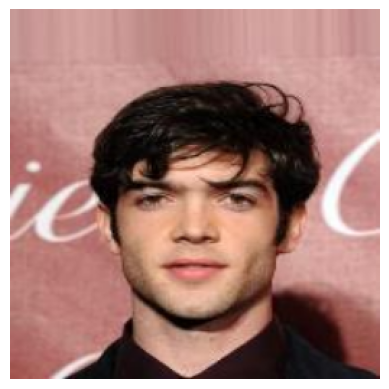

In [237]:
show_tensor_image(test_sample["gt_image"])

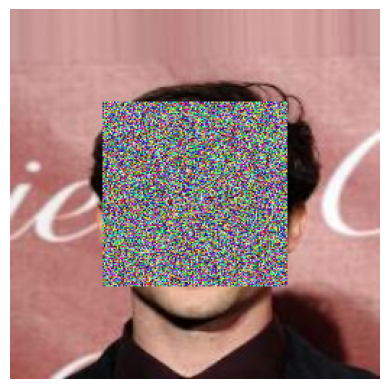

In [238]:
show_tensor_image(test_sample["cond_image"])

In [227]:
def inference(model, test_sample):
    with torch.no_grad():
        output, visuals = model.restoration(
            test_sample['cond_image'].unsqueeze(0).to(device),
            y_t=test_sample['cond_image'].unsqueeze(0).to(device),
            y_0=test_sample['cond_image'].unsqueeze(0).to(device),
            mask=test_sample['mask'].unsqueeze(0).to(device)
        )
    return output, visuals

In [228]:
output, visuals = inference(inpainting_model, test_sample)

In [229]:
visuals.shape

torch.Size([9, 3, 256, 256])

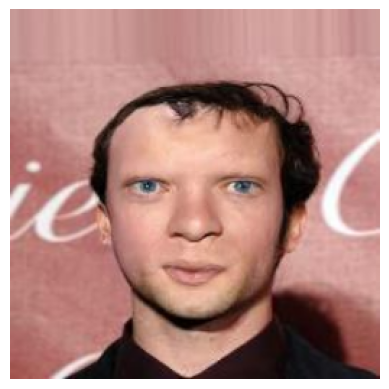

In [239]:
show_tensor_image(output.cpu())

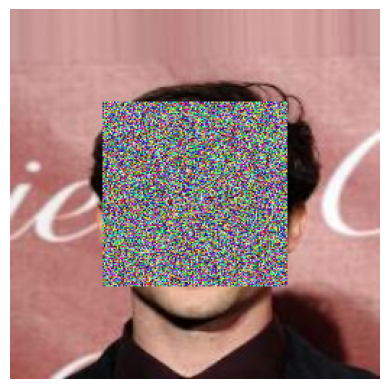

In [240]:
show_tensor_image(visuals[0].cpu())

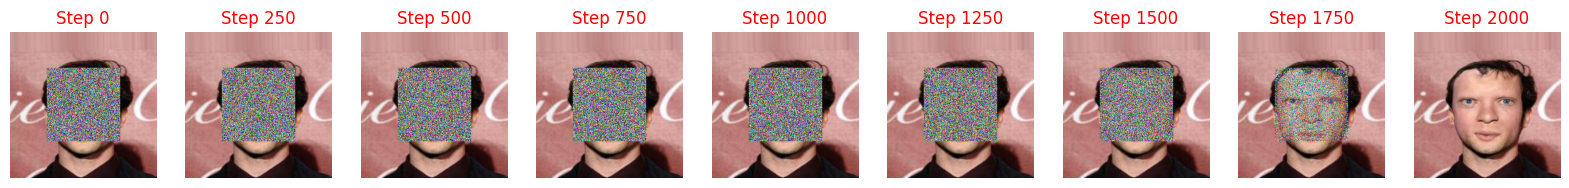

In [235]:
plt.figure(figsize=(20, 30))
num_images = len(visuals)  
total_steps = 2000
step_interval = total_steps // (num_images - 1)  

for i, visual in enumerate(visuals):
    plt.subplot(1, num_images, i + 1)
    show_tensor_image(visual.cpu())
    plt.axis("off")  
    step_number = i * step_interval  
    plt.title(f"Step {step_number}", fontsize=12, color="red")  

plt.show()